# Simple molecular dynamics simulation
Author: Shinji Iida

## Load library  to be used

In [1]:
using Random #for random number generation e.g., MersenneTwister()
using Plots  #for drawing a trajectory of a harmonic system and its energies.
include("systems.jl") 
using .HarmonicMod

# Euler method

In [2]:
function euler(x0::Float64, v0::Float64, dt::Float64, n_steps::Int, sys::System; outname = "traj_eu.dat")
    spring_const = sys.spring_const
    mass         = sys.mass 
    x_eq         = sys.x_eq 
    
    # --- Initialization ---
    x_t  = x0
    v_t  = v0 
    PE   = potential(x_t, x_eq, spring_const)
    f_t  = force(x_t, x_eq, spring_const) 
    KE   = kinetic_energy(v_t, mass)
    H    = PE + KE
    a_t  = f_t / mass
    
    # --- main loop ---
    fout = open(outname, "w");
    write(fout, "$x_t $v_t $PE $KE $H \n")
    for i in 1:n_steps
        x_t = x_t + v_t * dt
        PE  = potential(x_t, x_eq, spring_const) 
        f_t = force(x_t, x_eq, spring_const) 
        a_t = f_t / mass
        v_t = v_t + a_t * dt
        KE  = kinetic_energy(v_t, mass)
        H   = PE + KE
        write(fout, "$x_t $v_t $PE $KE $H \n")
    end
    close(fout)
    return nothing
    
    
end

euler (generic function with 1 method)

## Start to simulate

In [3]:
mass = 1.0
x_eq = 0.0
k    = 1.0

x0   = 1.0
v0   = 0.0 #For comparison with a circle with radius of one. We usually set this by gaussian()
dt   = 0.1
n_steps = 10^2
sys = System(mass, k, x_eq)
@time euler(x0, v0, dt, n_steps, sys, outname="traj_dt_eu.dat")

  0.013424 seconds (27.43 k allocations: 1.748 MiB, 95.16% compilation time)


### Check the energy conservation

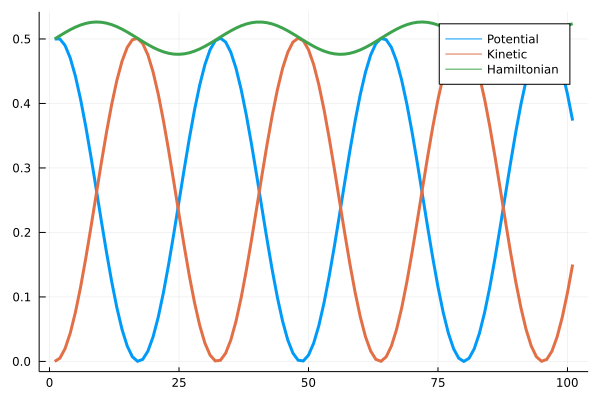

In [4]:
function draw_energy(filename)
    fin = open(filename, "r")
    ps = []
    ks = []
    hs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(ps,parse(Float64, pe))
        push!(ks,parse(Float64, ke))
        push!(hs,parse(Float64, h))
    end
    plot(1:length(ps),[ps,ks,hs], label=["Potential" "Kinetic" "Hamiltonian"], linewidth=3) #label: do not add comma!
end

draw_energy("traj_dt_eu.dat")

### View the phase space and compare it with a circle with radius of 1.
In my simulation, $m=1$, $k=1$ is assumed, and hence the resultant trajectory must follow the circule $\frac{1}{2}v^2 + \frac{1}{2}(x - x_{\mathrm{eq}})^2 = H$. 
Since we set 
$v_0 = 0$, 
$x_0 = 1$, 
$x_{\mathrm{eq}} = 0$
, we get $H=0.5$ (as shown above).
Therefore, we expect the trajectory to trace $\frac{1}{2}v^2 + \frac{1}{2}x^2 = 0.5 \Rightarrow v^2 + x^2 = 1$.
Let's see if we can get it.

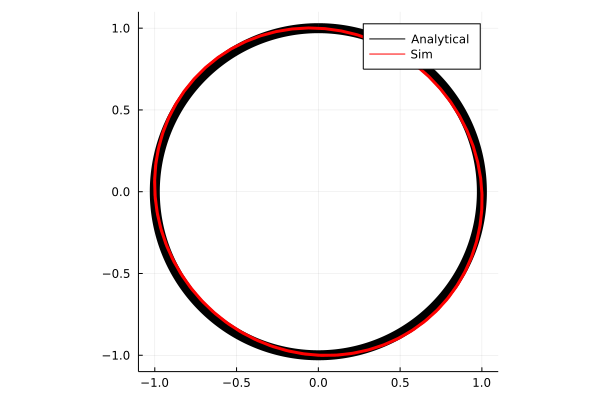

In [5]:
function get_traj(filename)
    fin = open(filename, "r")
    xs = []
    vs = []
    for line in eachline(fin)
        x, v, pe, ke, h = split(line)
        push!(xs,parse(Float64, x))
        push!(vs,parse(Float64, v))
    end
    return xs, vs
end

function circuleShape(h, k, r)
    # (r*sinθ)^2 + (r*cosθ)^2 
    θ = LinRange(0, 2π, 500)
    (h .+ r*sin.(θ), k .+r*cos.(θ))
end
xs, vs = get_traj("traj_dt_eu.dat")

xlims = (-1.1,1.1)
ylims = (-1.1,1.1)

p1 = plot(circuleShape(0,0,1),xlims = xlims, ylims = ylims,c = :red, lw = 10, 
    linecolor = :black, label = "Analytical", fillalpha = 0.0, aspect_ratio = 1)

p2 = plot!((xs, vs), xlims = xlims, ylims = ylims, c = :red, lw = 3., 
    linecolor = :red, label = "Sim", fillalpha = 0.2, aspect_ratio = 1)
#plot(p1, p2)

## With larger $dt$

In [6]:
mass = 1.0
x_eq = 0.0
k    = 1.0

x0   = 1.0
v0   = 0.0 
dt   = 1.5 #<= 
n_steps = 10^2
sys = System(mass, k, x_eq)
@time euler(x0, v0, dt, n_steps, sys, outname = "traj_eu_dt15.dat")

  0.000388 seconds (1.83 k allocations: 246.984 KiB)


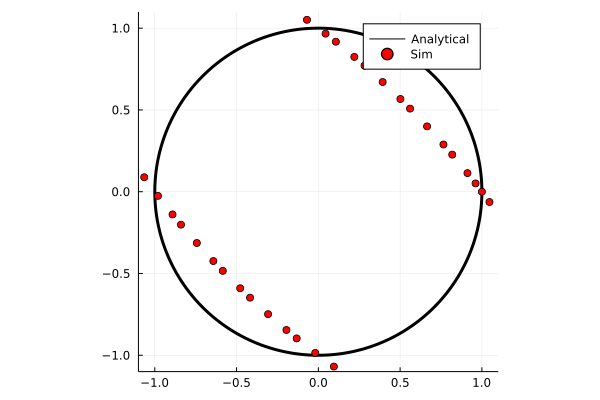

In [7]:
xs, vs = get_traj("traj_eu_dt15.dat")

p1 = plot(circuleShape(0,0,1),xlims = xlims, ylims = ylims,c = :red, lw = 3, 
    linecolor = :black, label = "Analytical", fillalpha = 0.0, aspect_ratio = 1)

p2 = scatter!((xs, vs), xlims = xlims, ylims = ylims, c = :red, lw = 3., 
    linecolor = :red, label = "Sim", fillalpha = 0.2, aspect_ratio = 1)


# Movie

┌ Info: Saved animation to 
│   fn = /Users/siida/Dropbox/01code/software/myTools/julimd/notebooks/anim_fps15.gif
└ @ Plots /Users/siida/.julia/packages/Plots/kyYZF/src/animation.jl:104


Plots.AnimatedGif("/Users/siida/Dropbox/01code/software/myTools/julimd/notebooks/anim_fps15.gif")
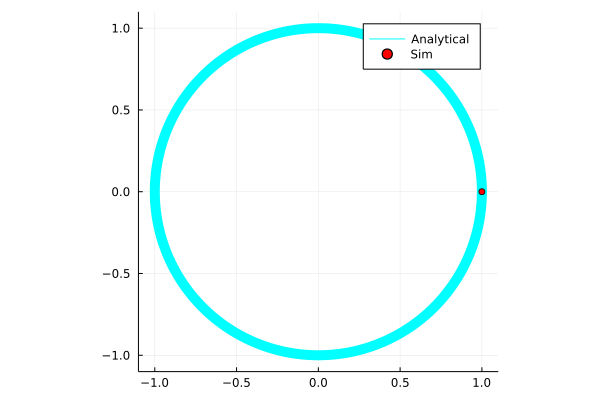

In [8]:
xs, vs = get_traj("traj_dt_eu.dat")
anim = @animate for i in 1:length(xs)
    plot(circuleShape(0,0,1),xlims = xlims, ylims = ylims, lw = 10, 
    linecolor = :cyan, label = "Analytical", fillalpha = 0.0, aspect_ratio = 1)
    
    scatter!((xs[i], vs[i]), xlims = xlims, ylims = ylims, c = :red, label = "Sim", 
        fillalpha = 0.2, aspect_ratio = 1)
end

gif(anim, "anim_fps15.gif", fps = 15)